In [2]:
ls

(訳)重力モデルに基づくCOVID.docx
Buying time- an ecological survival analysis of COVID-19 spread based on the gravity model .pdf
covid19.R
covid19.ipynb
covid19.pdf
covidモデリングメモ.rtf
data_covid.csv
data_covid.xlsx
data_covid_new.xlsx
exam_698ba7fed_Q-MaximumLikelihoodEstim...er · recruit-skillcheck_exam_698ba7fed.pdf
中国四川省での退院までの期間.pdf


In [13]:
import os
os.getcwd()

'/Users/masanoritakahashi/Documents/講義/ゼミ/M2/空間生存時間/論文/covid19'

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from lifelines import KaplanMeierFitter
from lifelines import CoxPHFitter
from lifelines.statistics import logrank_test
from lifelines import WeibullAFTFitter


import warnings
warnings.simplefilter('ignore')

In [5]:
#df2 = pd.read_excel("data_covid.xlsx")
df = pd.read_excel("data_covid_new.xlsx")

In [7]:
df.head()

,country,pop,urb,gdp,dist,hf,pf,ef,date_first,detection,status,cumul,air
0,Albania,2866376,60.319,13364.155397,6.996524e+06,7.84,8.005411,7.67,70,74.3,1,108641,303.14
1,Algeria,42228429,72.629,15481.787620,9.108277e+06,4.99,5.201489,4.77,58,12.0,1,80272,6442.44
2,Angola,30809762,65.514,6452.355165,1.049012e+07,5.40,5.979936,4.83,83,17.9,1,303691,76.94
3,Argentina,44494502,91.870,20610.568550,1.902562e+07,6.86,8.044600,5.67,65,74.9,1,92122,1516.63
4,Armenia,2951776,63.149,10343.175590,5.064044e+06,7.42,7.145017,7.70,62,60.8,1,86276,NaN


## 変数名  
- country・・・国名  	
- pop・・・人口  	
- urb・・・都市化の度合い(the degree of urbanization)  	
- gdp・・・GDP  	
- dist・・・発病国（中国）までの距離(the distance from country i to the country where the disease originated (China))	  
- hf・・・国iにおける人間的自由度の指標(a measure of human freedom in country i)  	
- pf・・・	国iにおける個人的自由度の指標(a measure of Personal freedom in country i) 
- ef・・・国iにおける経済的自由度の指標(a measure of economic freedom in country i)  	   
- date_first・・・生存時間   	
- detection・・・疫学的発見能力(the epidemiological detection capacity)	  	
- air・・・空の移動量(the volume of air travel)  
  
##  2.2. データソース   
- 発生開始から各国での最初の症例発生までの時間は、4月11日のCOVID-19に関するECDC公開データから収集した（ECDC, 2020a）。  
- 𝐻_iの指標として、2019年人間の自由度指数（HFI）を用いた（ケイトー研究所、2019年）。  
- 一人当たりGDP、都市化率、航空輸送（総搭乗者数）のデータは、最新の利用可能な世界銀行のデータセットから取得した（World Bank, n.d.）。  
- 検知および報告能力に関する措置は、2019 Global Health Security Index（ジョンズ・ホプキンス・センター・フォー・ヘルスセキュリティ、2019年）から抽出した。  
- 国と中国のセントロイド間の距離は、Rパッケージgeosphereを用いて計算した（Robert J. Hijmans, 2019）。  

In [442]:
df

,country,pop,urb,gdp,dist,hf,pf,ef,date_first,detection,air
0,Albania,2866376,60.319,13364.155397,6.996523e+06,7.84,8.005411,7.67,2020-03-09,74.3,303.14
1,Algeria,42228429,72.629,15481.787620,9.108276e+06,4.99,5.201489,4.77,2020-02-26,12.0,6442.44
2,Angola,30809762,65.514,6452.355165,1.049012e+07,5.40,5.979936,4.83,2020-03-22,17.9,76.94
3,Argentina,44494502,91.870,20610.568550,1.902562e+07,6.86,8.044600,5.67,2020-03-04,74.9,1516.63
4,Armenia,2951776,63.149,10343.175590,5.064043e+06,7.42,7.145017,7.70,2020-03-01,60.8,NaN
...,...,...,...,...,...,...,...,...,...,...,...
151,Venezuela,28870195,88.208,18102.500000,1.505806e+07,3.80,5.027017,2.58,2020-03-15,8.7,2137.77
152,Vietnam,95540395,35.919,7447.814334,2.220675e+06,6.29,6.310973,6.27,2020-01-24,57.4,47049.67
153,Yemen,28498687,36.642,2575.126385,5.972542e+06,4.30,2.750150,5.84,2020-04-10,9.0,336.31
154,Zambia,17351822,43.521,4223.906936,9.685536e+06,6.49,6.133478,6.84,2020-03-19,21.9,8.90


# 前処理

In [443]:
# 中国初感染日(2019/12/31)から各国初感染日までの日数
china_time = datetime.datetime(year=2019, month=12, day=31)
df["day_from_china"] = (df["date_first"] - china_time).apply(lambda x:x.days)+1

In [444]:
"""len(df[df["air"]==0])

# airの欠損(2ヵ国)及び0(3ヵ国)を削除
df.dropna(inplace=True)
df=df[df["air"]!=0]

# 中国は削除
df[df["country"]=="China"]

df = df[df["country"]!="China"]"""

'len(df[df["air"]==0])\n\n# airの欠損(2ヵ国)及び0(3ヵ国)を削除\ndf.dropna(inplace=True)\ndf=df[df["air"]!=0]\n\n# 中国は削除\ndf[df["country"]=="China"]\n\ndf = df[df["country"]!="China"]'

In [445]:
df.isnull().sum()

country           0
pop               0
urb               0
gdp               0
dist              0
hf                0
pf                0
ef                0
date_first        0
detection         0
air               2
day_from_china    0
dtype: int64

In [446]:
df.describe()

,pop,urb,gdp,dist,hf,pf,ef,detection,air,day_from_china
count,1.560000e+02,156.000000,156.000000,1.560000e+02,156.000000,156.000000,156.000000,156.000000,1.540000e+02,156.000000
mean,4.726514e+07,60.906058,22785.383218,8.421274e+06,6.898333,6.998233,6.798526,48.011538,4.202665e+05,63.794872
std,1.595654e+08,21.878851,23064.988229,4.060722e+06,1.074836,1.416376,0.919409,22.127528,4.926299e+06,18.809990
min,9.676200e+04,13.032000,744.182072,0.000000e+00,3.800000,2.750150,2.580000,6.100000,0.000000e+00,1.000000
25%,4.125332e+06,43.480750,5558.679472,5.967468e+06,6.217500,5.977194,6.207500,33.250000,3.345025e+02,59.000000
50%,1.062855e+07,62.019000,15247.358944,7.652213e+06,6.835000,6.970948,6.875000,44.450000,2.200235e+03,67.500000
75%,3.428224e+07,79.530500,32419.656341,1.062819e+07,7.740000,8.041411,7.495000,64.550000,1.325847e+04,76.000000
max,1.392730e+09,100.000000,126898.425932,1.957707e+07,8.880000,9.445978,8.710000,98.200000,6.114938e+07,102.000000


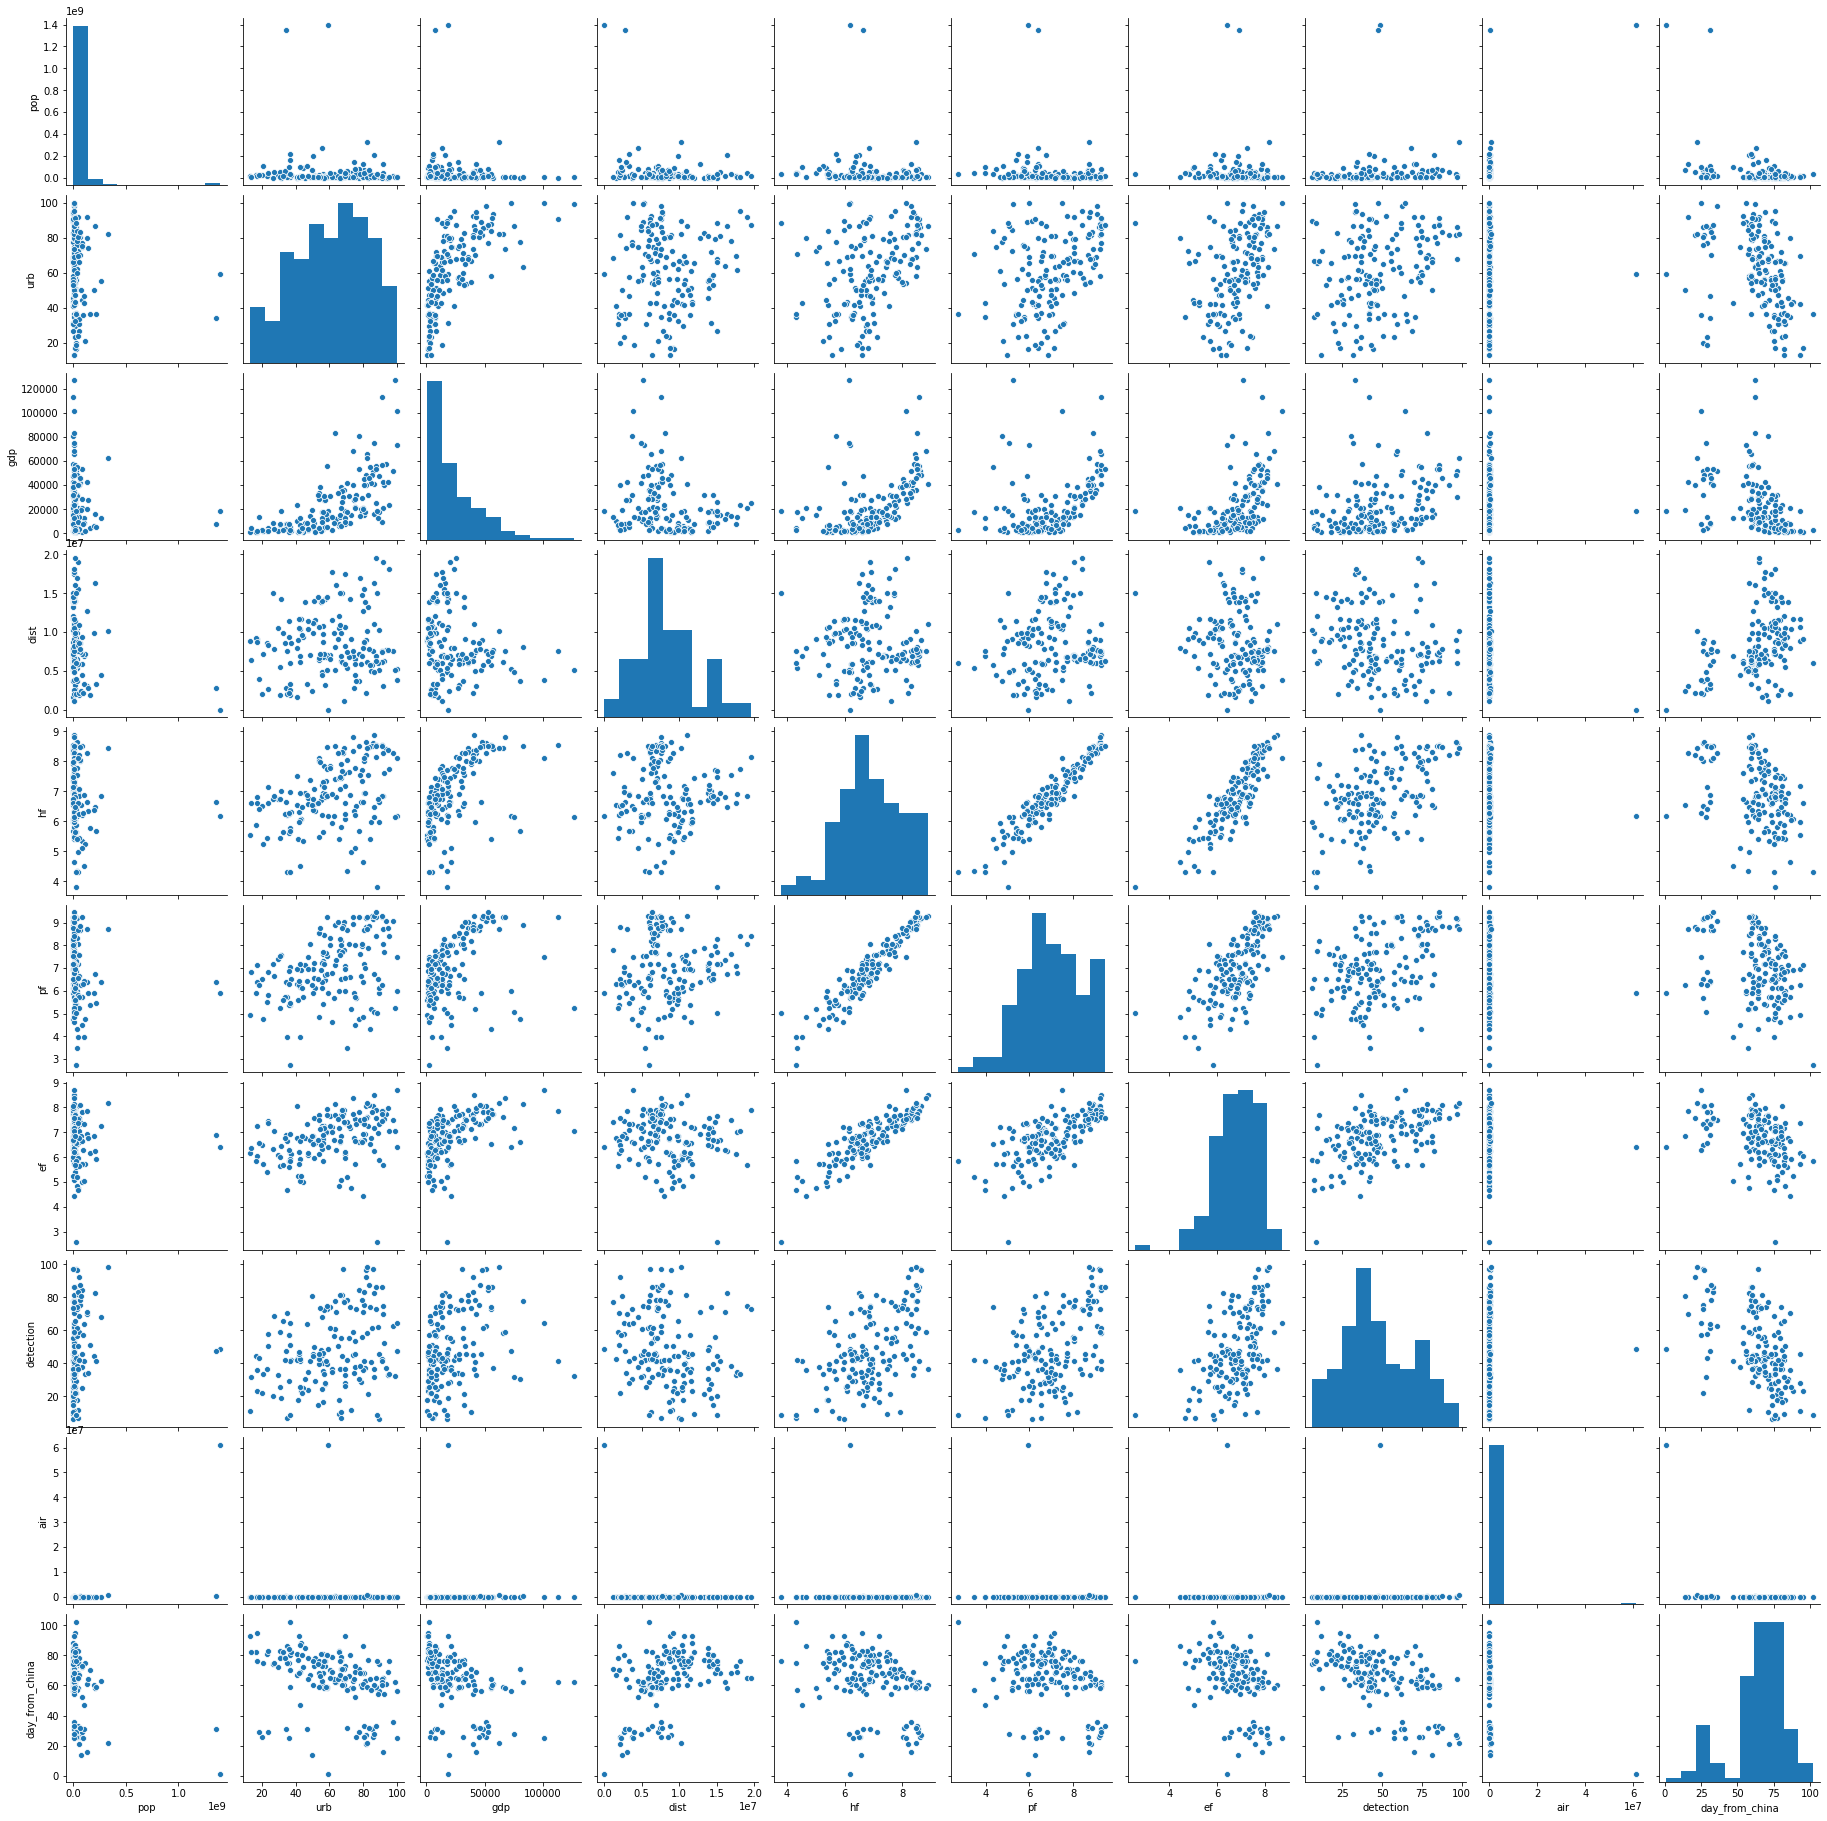

In [447]:
sns.pairplot(data=df, palette='Blues')

# 中央値で2値化

In [448]:
print("人口の中央値："+str(df["pop"].median()))
print("都会化度合いの中央値："+str(df["urb"].median()))
print("GDPの中央値："+str(df["gdp"].median()))
print("中国からの距離の中央値："+str(df["dist"].median()))
print("人間的自由度の指標の中央値："+str(df["hf"].median()))
print("経済的自由度の指標の中央値："+str(df["ef"].median()))
print("個人的自由度の指標の中央値："+str(df["pf"].median()))
print("疫学的発見能力の移動量："+str(df["detection"].median()))
print("空の移動量："+str(df["air"].median()))

人口の中央値：10628546.5
都会化度合いの中央値：62.019000000000005
GDPの中央値：15247.358943557634
中国からの距離の中央値：7652213.3919498585
人間的自由度の指標の中央値：6.835
経済的自由度の指標の中央値：6.875
個人的自由度の指標の中央値：6.970948385933633
疫学的発見能力の移動量：44.45
空の移動量：2200.2349999999997


In [449]:
# pop
df["pop_median"]=0 
df.loc[df["pop"]>=df["pop"].median(), "pop_median"] = 1

# urb
df["urb_median"]=0 
df.loc[df["urb"]>=df["urb"].median(), "urb_median"] = 1

# gdp
df["gdp_median"]=0 
df.loc[df["gdp"]>=df["gdp"].median(), "gdp_median"] = 1

# dist
df["dist_median"]=0 
df.loc[df["dist"]>=df["dist"].median(), "dist_median"] = 1

# hf
df["hf_median"]=0 
df.loc[df["hf"]>=df["hf"].median(), "hf_median"] = 1

# ef
df["ef_median"]=0 
df.loc[df["ef"]>=df["ef"].median(), "ef_median"] = 1

# pf
df["pf_median"]=0 
df.loc[df["pf"]>=df["pf"].median(), "pf_median"] = 1

# pf
df["detection_median"]=0 
df.loc[df["detection"]>=df["detection"].median(), "detection_median"] = 1

# air
df["air_median"]=0 
df.loc[df["air"]>=df["air"].median(), "air_median"] = 1

In [450]:
len(df[df["air"]==0])

# airの欠損(2ヵ国)及び0(3ヵ国)を削除
df.dropna(inplace=True)
df=df[df["air"]!=0]

# 中国は削除
df[df["country"]=="China"]

df = df[df["country"]!="China"]

Text(0.5, 1.0, 'Births and deaths of our population, at $t=10$')

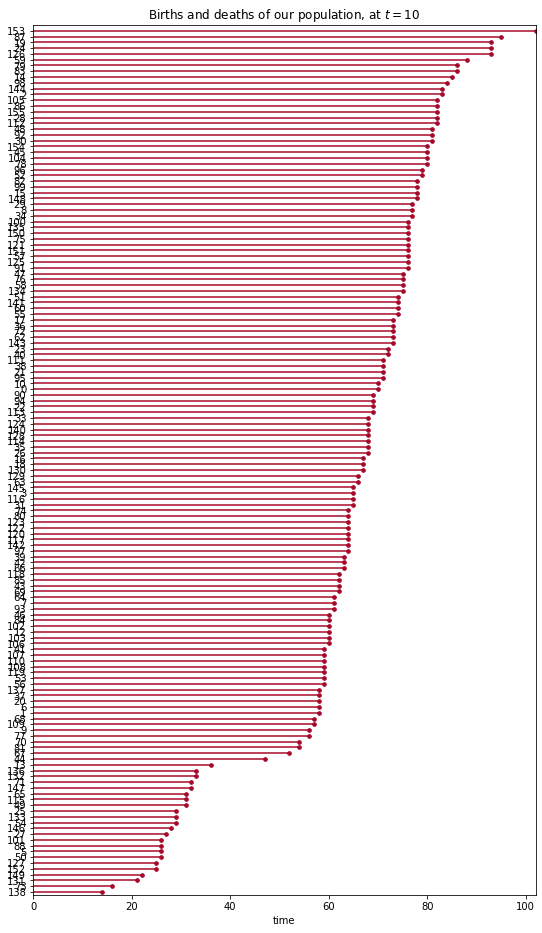

In [451]:
from lifelines.plotting import plot_lifetimes
fig = plt.figure(figsize=(9,16))
ax = plot_lifetimes(df["day_from_china"])

ax.set_xlim(0,df["day_from_china"].max() )
#ax.vlines(10, 0, 30, lw=2, linestyles='--')
ax.set_xlabel("time")
ax.set_title("Births and deaths of our population, at $t=10$")

# Kaplan-Meier Plot

生存時間の中央値：67.0


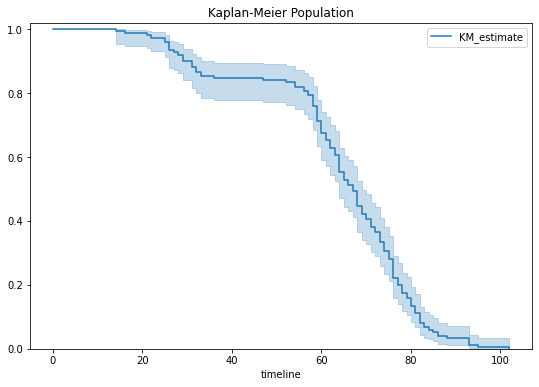

In [452]:
fig=plt.figure(figsize=(9, 6))

kmf = KaplanMeierFitter()
kmf.fit(df["day_from_china"])
kmf.plot()
plt.ylim(0, 1.02);
plt.title("Kaplan-Meier Population");
print("生存時間の中央値：" + str(kmf.median_survival_time_))

In [453]:
def kaplan_plot(df, col_name):
    fig=plt.figure(figsize=(9, 6))
    ax = plt.subplot(111)

    dem = (df[col_name] == 1)
    T = df["day_from_china"]
    kmf.fit(T[dem], label="High")
    print(f"{col_name[:-7]}_Highの中央生存時間：" + str(kmf.median_survival_time_))
    kmf.plot(ax=ax)

    kmf.fit(T[~dem],  label="Low")
    print(f"{col_name[:-7]}_Lowの中央生存時間：" + str(kmf.median_survival_time_))
    kmf.plot(ax=ax)

    plt.ylim(0, 1.02);
    plt.title(f"Kaplan-Meier {col_name[:-7]}");
    
    print("↓ログランク検定結果↓")
    result=logrank_test(T[dem],T[~dem])
    print(result.print_summary())

pop_Highの中央生存時間：64.0
pop_Lowの中央生存時間：69.0
↓ログランク検定結果↓


None


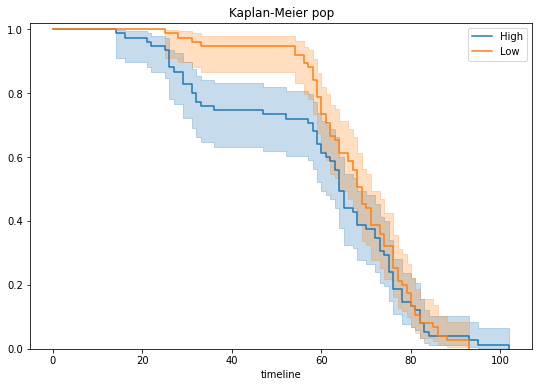

In [454]:
kaplan_plot(df, "pop_median")

urb_Highの中央生存時間：62.0
urb_Lowの中央生存時間：74.0
↓ログランク検定結果↓


None


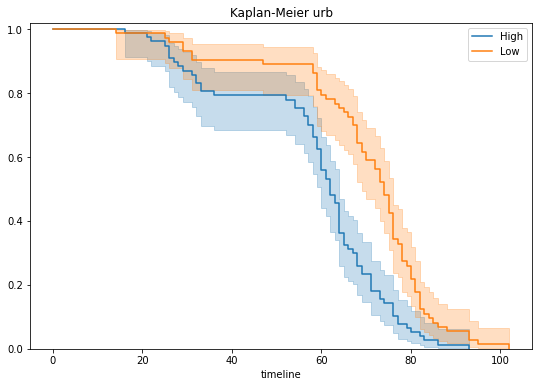

In [455]:
kaplan_plot(df, "urb_median")

gdp_Highの中央生存時間：60.0
gdp_Lowの中央生存時間：74.0
↓ログランク検定結果↓


None


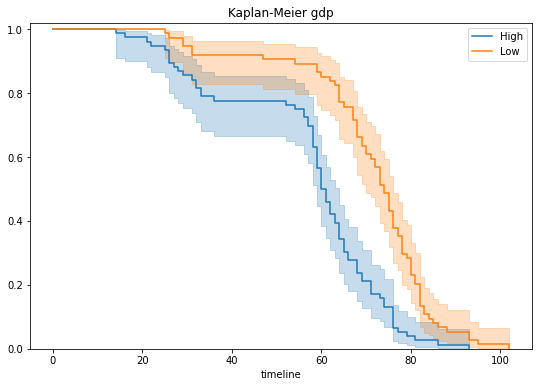

In [456]:
kaplan_plot(df, "gdp_median")

dist_Longの中央生存時間：74.0
dist_Shortの中央生存時間：60.0
↓ログランク検定結果↓


None


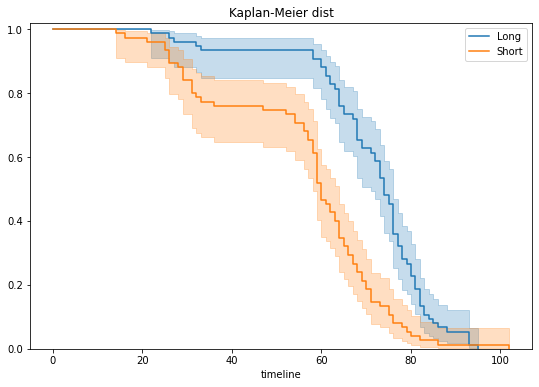

In [457]:
# dist
ig=plt.figure(figsize=(9, 6))
ax = plt.subplot(111)

dem = (df["dist_median"] == 1)
T = df["day_from_china"]
kmf.fit(T[dem], label="Long")
print("dist_Longの中央生存時間：" + str(kmf.median_survival_time_))
kmf.plot(ax=ax)

kmf.fit(T[~dem],  label="Short")
print("dist_Shortの中央生存時間：" + str(kmf.median_survival_time_))
kmf.plot(ax=ax)

plt.ylim(0, 1.02);
plt.title("Kaplan-Meier dist");

print("↓ログランク検定結果↓")
results=logrank_test(T[dem],T[~dem])
print(results.print_summary())

hf_Highの中央生存時間：64.0
hf_Lowの中央生存時間：72.0
↓ログランク検定結果↓


None


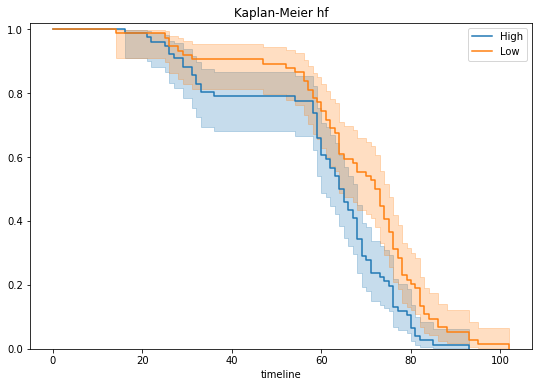

In [458]:
kaplan_plot(df, "hf_median")

ef_Highの中央生存時間：62.0
ef_Lowの中央生存時間：73.0
↓ログランク検定結果↓


None


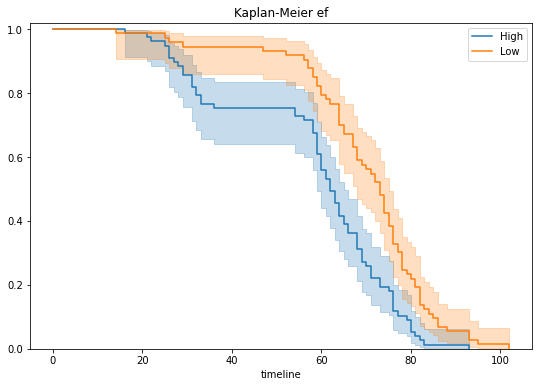

In [459]:
kaplan_plot(df, "ef_median")

pf_Highの中央生存時間：65.0
pf_Lowの中央生存時間：72.0
↓ログランク検定結果↓


None


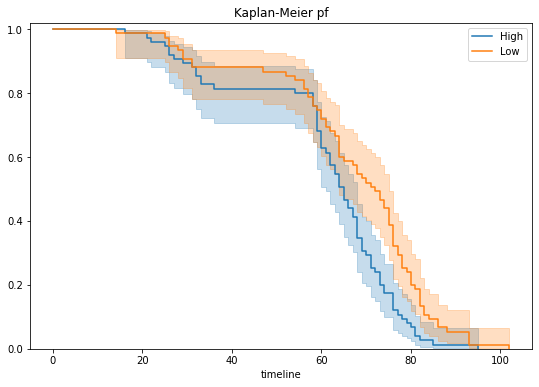

In [460]:
kaplan_plot(df, "pf_median")

detection_Highの中央生存時間：61.0
detection_Lowの中央生存時間：74.0
↓ログランク検定結果↓


None


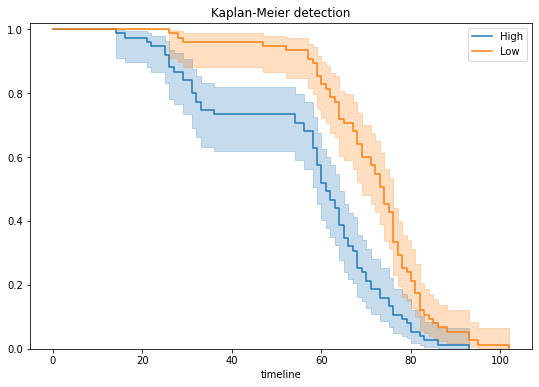

In [461]:
kaplan_plot(df, "detection_median")

air_Highの中央生存時間：59.0
air_Lowの中央生存時間：76.0
↓ログランク検定結果↓


None


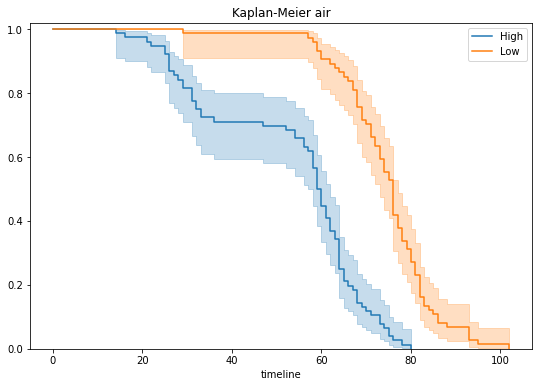

In [462]:
kaplan_plot(df, "air_median")

In [463]:
df["status"]=1

In [464]:
#df.to_csv("data_covid.csv", index=False)

# Cox比例ハザードモデル

In [465]:
df.columns

Index(['country', 'pop', 'urb', 'gdp', 'dist', 'hf', 'pf', 'ef', 'date_first',
       'detection', 'air', 'day_from_china', 'pop_median', 'urb_median',
       'gdp_median', 'dist_median', 'hf_median', 'ef_median', 'pf_median',
       'detection_median', 'air_median', 'status'],
      dtype='object')

In [466]:
df_cox_hf = df[['day_from_china', 'status', 'pop_median', 'urb_median', 'gdp_median',
                'dist_median', 'hf_median',  'detection_median', 'air_median']]

df_cox_ef = df[['day_from_china', 'status', 'pop_median', 'urb_median', 'gdp_median',
                'dist_median',  'ef_median', 'pf_median', 'detection_median', 'air_median']]

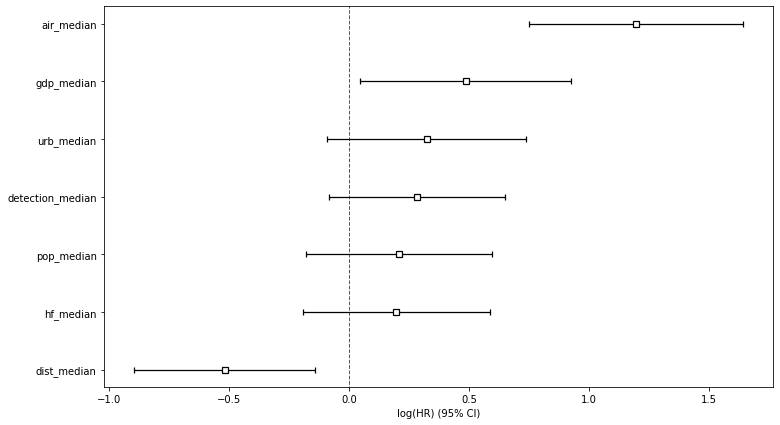

In [467]:
cph = CoxPHFitter()
cph.fit(df_cox_hf, duration_col='day_from_china', event_col='status')

cph.print_summary()  # access the results using cph.summary

fig=plt.figure(figsize=(12,7))
cph.plot()

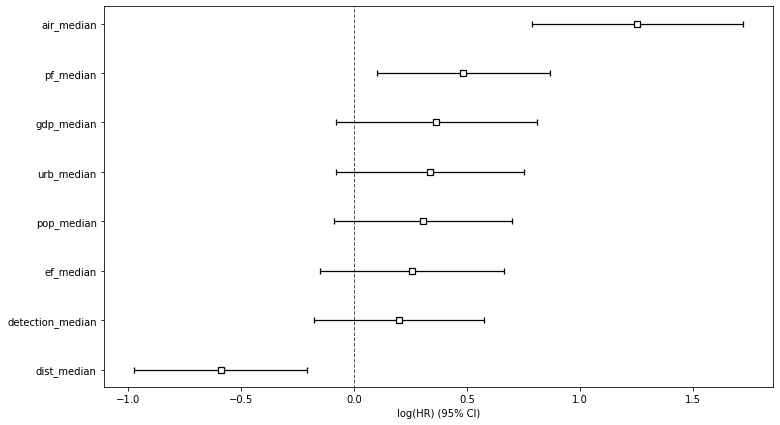

In [468]:
cph = CoxPHFitter()
cph.fit(df_cox_ef, duration_col='day_from_china', event_col='status')

cph.print_summary()  # access the results using cph.summary

fig=plt.figure(figsize=(12,7))
cph.plot()

# 故障加速モデル

In [469]:
aft = WeibullAFTFitter()
aft.fit(df_cox_hf, duration_col='day_from_china', event_col='status')
aft.print_summary() 

In [470]:
aft = WeibullAFTFitter()
aft.fit(df_cox_ef, duration_col='day_from_china', event_col='status')
aft.print_summary() 

In [471]:
df

,country,pop,urb,gdp,dist,hf,pf,ef,date_first,detection,...,pop_median,urb_median,gdp_median,dist_median,hf_median,ef_median,pf_median,detection_median,air_median,status
0,Albania,2866376,60.319,13364.155397,6.996523e+06,7.84,8.005411,7.67,2020-03-09,74.3,...,0,0,0,0,1,1,1,1,0,1
1,Algeria,42228429,72.629,15481.787620,9.108276e+06,4.99,5.201489,4.77,2020-02-26,12.0,...,1,1,1,1,0,0,0,0,1,1
2,Angola,30809762,65.514,6452.355165,1.049012e+07,5.40,5.979936,4.83,2020-03-22,17.9,...,1,1,0,1,0,0,0,0,0,1
3,Argentina,44494502,91.870,20610.568550,1.902562e+07,6.86,8.044600,5.67,2020-03-04,74.9,...,1,1,1,1,1,0,1,1,0,1
5,Australia,24992369,86.012,51663.365095,7.608912e+06,8.62,9.160533,8.07,2020-01-25,97.3,...,1,1,1,0,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151,Venezuela,28870195,88.208,18102.500000,1.505806e+07,3.80,5.027017,2.58,2020-03-15,8.7,...,1,1,1,1,0,0,0,0,0,1
152,Vietnam,95540395,35.919,7447.814334,2.220675e+06,6.29,6.310973,6.27,2020-01-24,57.4,...,1,0,0,0,0,0,0,1,1,1
153,Yemen,28498687,36.642,2575.126385,5.972542e+06,4.30,2.750150,5.84,2020-04-10,9.0,...,1,0,0,0,0,0,0,0,0,1
154,Zambia,17351822,43.521,4223.906936,9.685536e+06,6.49,6.133478,6.84,2020-03-19,21.9,...,1,0,0,1,0,0,0,0,0,1
